## Loading Data from Kaggle

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

In [ ]:
CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ravdess-emotional-speech-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107620%2F256618%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240628%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240628T181526Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db54349a782fae12a34e6ac52b3a88ece6754d5a4313b853938b9ad5642d8f139750b7662749564a235d38914c8bc250f98768acd27e754f1c3f75124d156a7c180aa5442c3d719825cf74c1995a0bc250987f9601ac605e6d9e663c65a0ab6b715fe82ffe49af7c7090f67fffadce2797e2635a8fc78e08bb0fc5aa195058f1553ae78e0854ad8912fbcc7e8d17b0568dddf15e2f6a7e02ffe2c026d56ead837a317853a653096527323af76746a645cd320f757cd73aae29242d7dde151eb47ce9df554eda824e740b9ea80a8096d31634bfac38e4b3962c1352b82baf07f96d24af59786cee067623df36a02c169ad5e5161908ec29c09d735438e4108e3d2,toronto-emotional-speech-set-tess:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F316368%2F639622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240628%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240628T181526Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6b65a19bb8a28963092b74ea1992d8ce74c3c482129d06abe27ce8a77bbb6f5aae49cec6423195e68b34c83330466e18e1d350ebce81e5d399a53014f6e5346bcca9fbf0048ae5dade4c163939c3707a7da7d8b1cd68b7fbf883e99baae169b0bef8b11a0295055120ca6d06485c5286dceab4134851f523a7e590f3ef74d262afe343c1a4c11a483039c75359c29ecbff7e0ebd3b8a5b69c73a3846071daf8af421f55137675736a6e289cfec1f0bf68b30982f646d3ac38ad44066d1cfd2f42589ffadbc7d375ac988f8eb00e28cd0703acb59bd8946ec37fd81d24fab833595fc1f00fd05b69a6cfe82945800f8fad2fc4733f35da5c2632b39e068e3681e,cremad:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F325566%2F653195%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240628%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240628T181526Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7339aba7b4c1b2e489e1df2b5cc484ab05845f8ca851831573516b518757079d1672436030c16fa0b2d581bdd072276376181ae7f8c804847e7b60927f8f581fc261c0d4d4bd75c73aef8af5e849c4f9184c2c78a8ff4ef901c287922aa8ca72f355356eff9880679d658d131a9ef6d4123b7a88c4b66940ec846c0ed864d4356cfeb6da63cbd57dc92b2749f7a48a4273b29e16b0f0f89a1b503d7e785ee1adebcc352914c5d2b4b6d3bb69d7e3249ef60ee1ede15c92ec1b537050fdedd1635a9025e258d5d7e49636d615a6dc60513d50fb36651b91a0e13427fc6650ac66f302a4fcecf001edea88acb6db587afc4bff8a160f08f4f7cd1954389a226123,surrey-audiovisual-expressed-emotion-savee:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F338555%2F671851%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240628%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240628T181526Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D419dca6682d115d9e26bbfd4441d4d40cbc98b2a594dfca61ec23cb15e932b1a9a1166a2d0de1c9d02d01d751b436242f56cd217bf751bc1de48a8b421ad5f8826415e967f722d628480dfbe6b3ee3cca91e343483397cf48a3ebf91b5908d16d0877eca91fcae535a30cb13f1801701393afba436bca3b6c900a92cac52d587c447fe346d6c802d16d15d2283ec8e80af4834b4aae04d30a893cec6c2b85d06cb2b87805a8fe844f0a2cf648234202cb844d30064b36b3bb302963fcee1a709a76b3f7a096e80a57e84985c38f938dbbd0f925bb58be35f3681118348f89e8a0b97f0c9291665f2dd83a84eb4096df5cd93830e8562ba82530f87b1c3bf88b3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 450102890 bytes downloaded
Downloaded and uncompressed: ravdess-emotional-speech-audio
[==================================================] 448572034 bytes downloaded
Downloaded and uncompressed: toronto-emotional-speech-set-tess
[==================================================] 473324524 bytes downloaded
Downloaded and uncompressed: cremad
[==================================================] 112690765 bytes downloaded
Downloaded and uncompressed: surrey-audiovisual-expressed-emotion-savee
Data source import complete.


#  <center> Speech Emotion Recognition <center>

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preparation


In [ ]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

### 1.Ravdess Dataframe


In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1     happy  /kaggle/input/ravdess-emotional-speech-audio/a...
2       sad  /kaggle/input/ravdess-emotional-speech-audio/a...
3     angry  /kaggle/input/ravdess-emotional-speech-audio/a...
4      fear  /kaggle/input/ravdess-emotional-speech-audio/a...

### 2.Crema DataFrame

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  disgust  /kaggle/input/cremad/AudioWAV/1048_MTI_DIS_XX.wav
1     fear  /kaggle/input/cremad/AudioWAV/1015_IEO_FEA_MD.wav
2    happy  /kaggle/input/cremad/AudioWAV/1002_IEO_HAP_LO.wav
3     fear  /kaggle/input/cremad/AudioWAV/1074_TSI_FEA_XX.wav
4    angry  /kaggle/input/cremad/AudioWAV/1087_ITH_ANG_XX.wav

### 3.TESS dataset

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0     fear  /kaggle/input/toronto-emotional-speech-set-tes...
1     fear  /kaggle/input/toronto-emotional-speech-set-tes...
2     fear  /kaggle/input/toronto-emotional-speech-set-tes...
3     fear  /kaggle/input/toronto-emotional-speech-set-tes...
4     fear  /kaggle/input/toronto-emotional-speech-set-tes...

### 4.CREMA-D dataset  


In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0     angry  /kaggle/input/surrey-audiovisual-expressed-emo...
1       sad  /kaggle/input/surrey-audiovisual-expressed-emo...
2       sad  /kaggle/input/surrey-audiovisual-expressed-emo...
3   neutral  /kaggle/input/surrey-audiovisual-expressed-emo...
4  surprise  /kaggle/input/surrey-audiovisual-expressed-emo...

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1     happy  /kaggle/input/ravdess-emotional-speech-audio/a...
2       sad  /kaggle/input/ravdess-emotional-speech-audio/a...
3     angry  /kaggle/input/ravdess-emotional-speech-audio/a...
4      fear  /kaggle/input/ravdess-emotional-speech-audio/a...

## Data Visualisation and Exploration

### Count Plot

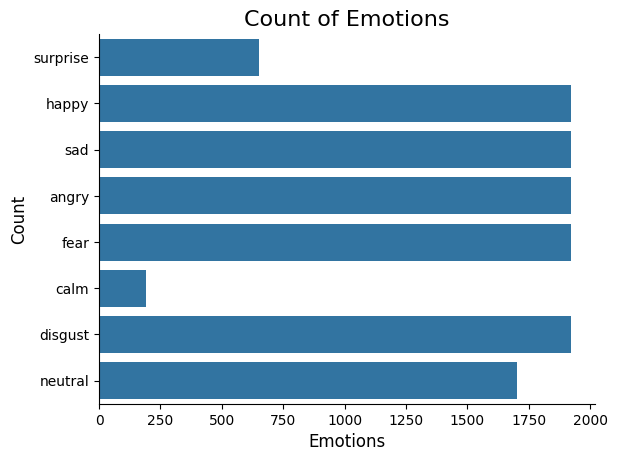

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

### Waveplot and Spectrogram

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [ ]:
!pip install librosa --upgrade # Upgrade librosa to the latest version

import librosa
import librosa.display
import matplotlib.pyplot as plt

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr) # Use waveshow instead of waveplot
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

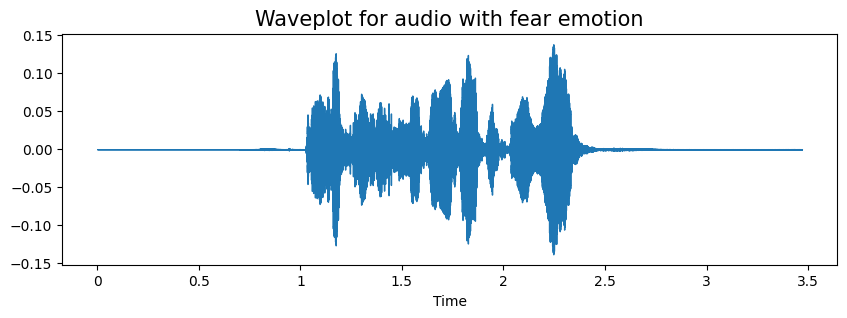

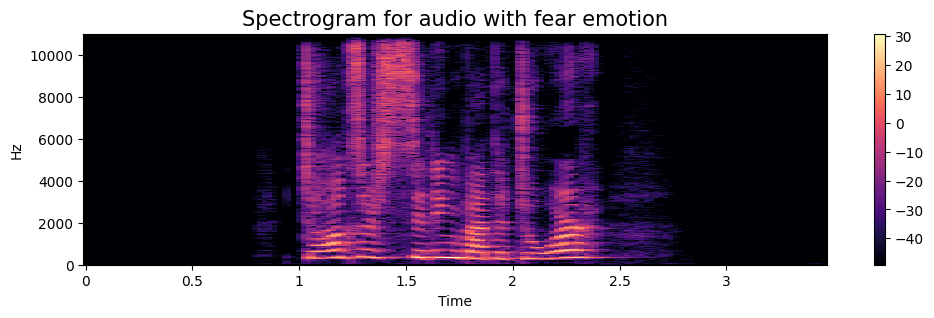

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

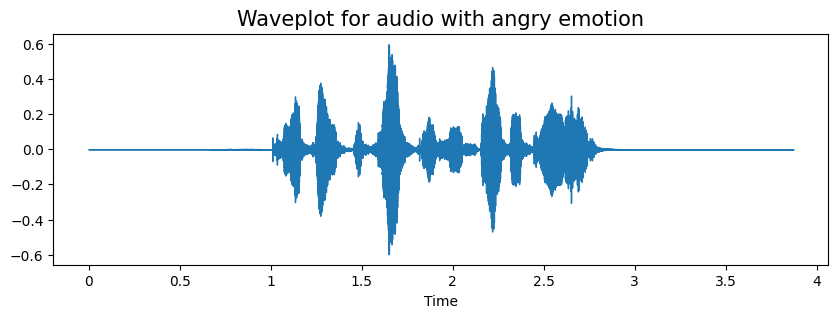

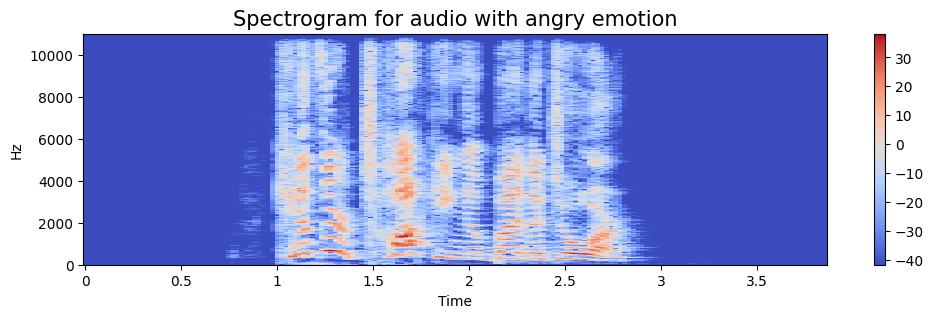

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

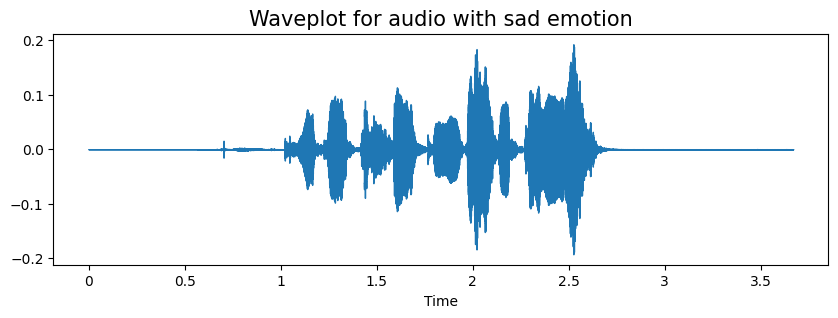

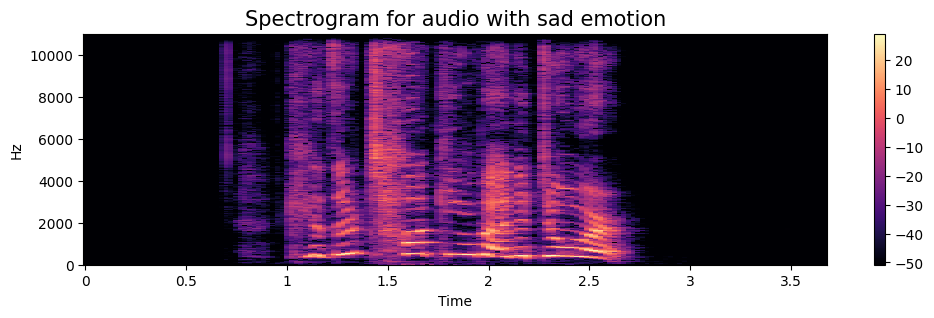

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

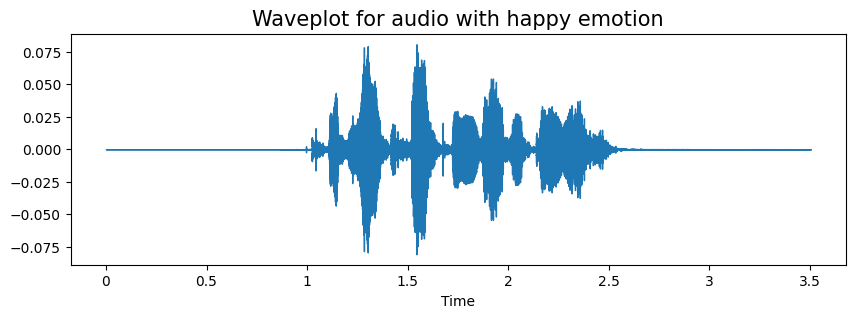

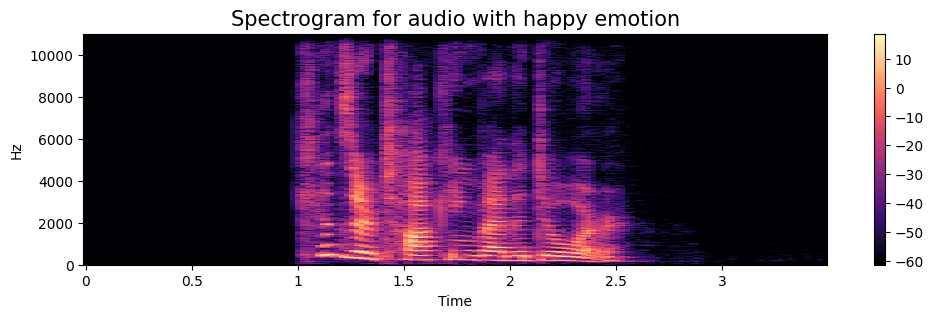

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation



In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

### 1. Simple Audio

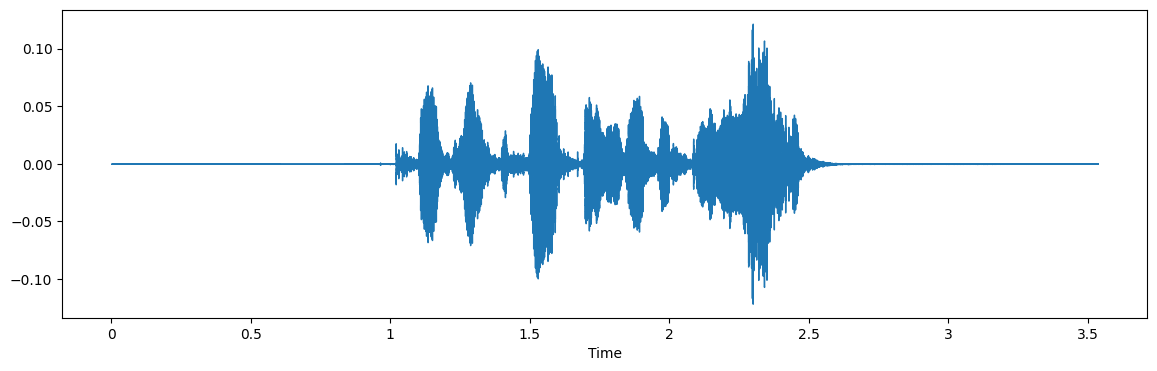

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

### 2. Noise Injection

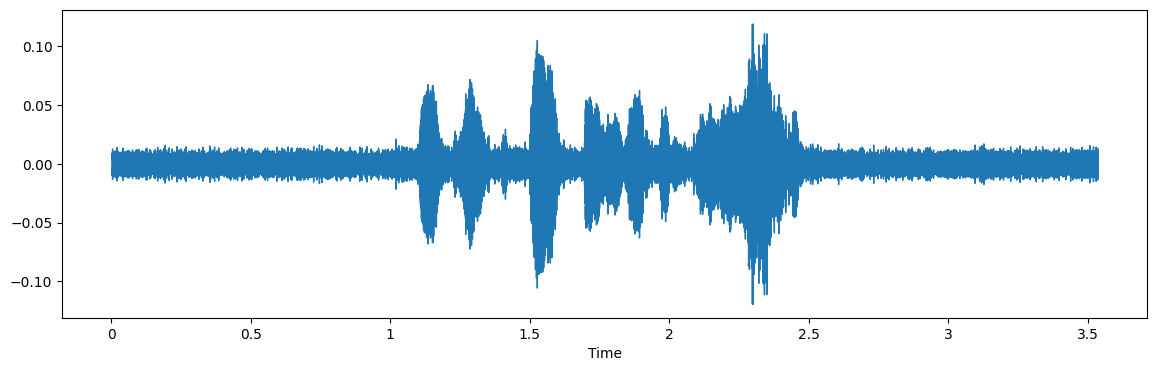

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### 3. Stretching

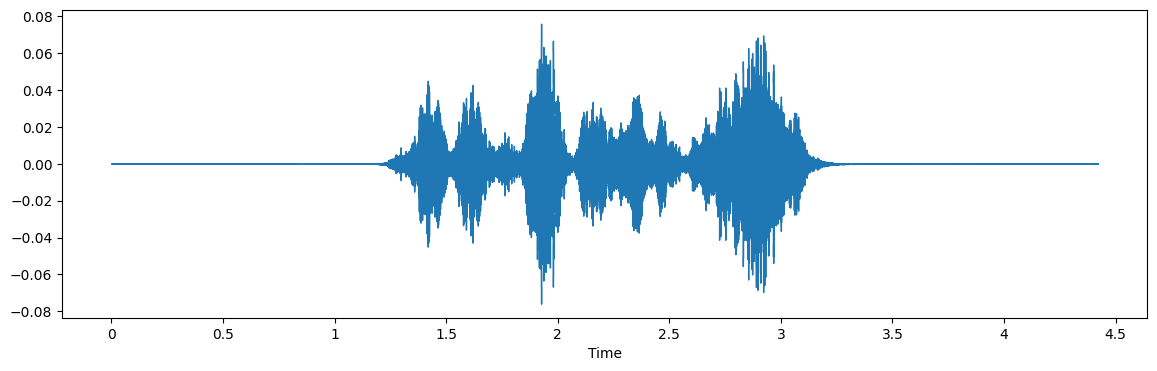

In [ ]:
!pip install --upgrade librosa

import librosa

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate) # Added the rate keyword argument
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### 4. Shifting

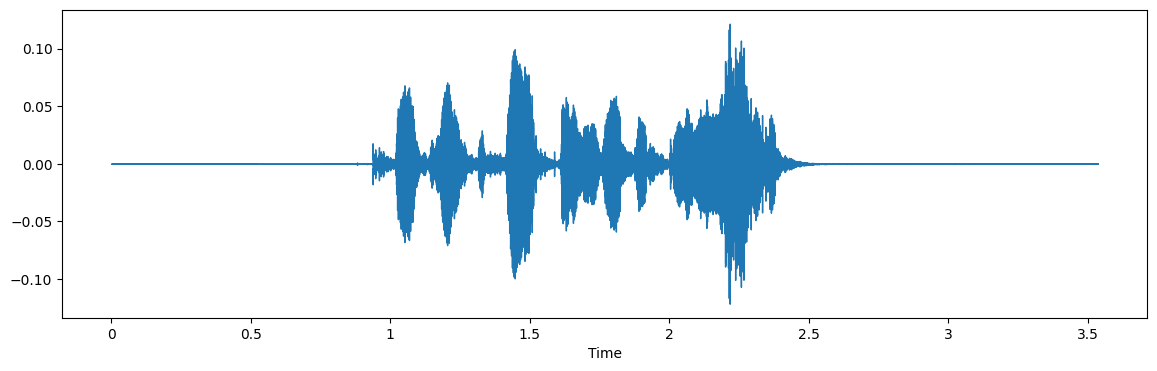

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### 5. Pitch

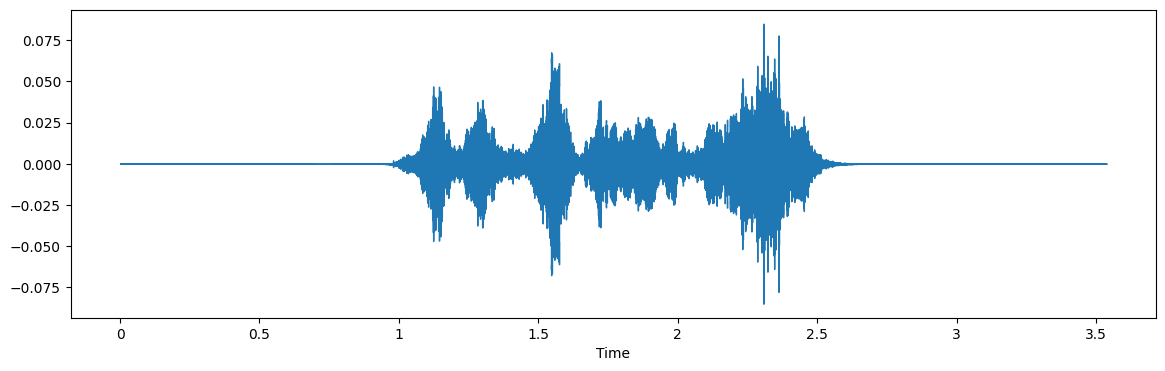

In [ ]:
def pitch(data, sampling_rate, pitch_factor=0.7):
    # Use keyword arguments for sampling_rate and pitch_factor
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Feature Extraction


In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.211286  0.591491  0.602619  0.573928  0.568875  0.567666  0.560707   
1  0.324368  0.731862  0.741935  0.735512  0.757421  0.770136  0.707971   
2  0.180519  0.606436  0.615857  0.612500  0.585965  0.575191  0.562262   
3  0.200485  0.554979  0.502475  0.539032  0.560833  0.535342  0.548914   
4  0.329228  0.738797  0.722371  0.755978  0.787787  0.766283  0.683192   

          7         8         9  ...       153       154       155       156  \
0  0.536210  0.583467  0.626053  ...  0.003376  0.006674  0.006952  0.009339   
1  0.637441  0.658457  0.676980  ...  0.009595  0.012672  0.014006  0.015763   
2  0.582958  0.588030  0.624002  ...  0.000922  0.000782  0.001140  0.001369   
3  0.621019  0.682764  0.643541  ...  0.000055  0.000068  0.000084  0.000087   
4  0.710083  0.725265  0.713964  ...  0.001059  0.001059  0.001087  0.001110   

        157       158       159       160       161    labels  
0  0.010989  0.008809  0.009711  0.004945  0.000514  surprise  
1  0.017727  0.014714  0.016214  0.011843  0.006941  surprise  
2  0.001660  0.002709  0.002598  0.000893  0.000119  surprise  
3  0.000053  0.000028  0.000025  0.000017  0.000002     happy  
4  0.001030  0.001034  0.001021  0.001014  0.001045     happy  

[5 rows x 163 columns]

## Data Preparation

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

## Modelling

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 208s 467ms/step - loss: 1.6795 - accuracy: 0.3196 - val_loss: 1.4699 - val_accuracy: 0.3986 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 195s 455ms/step - loss: 1.4282 - accuracy: 0.4255 - val_loss: 1.3136 - val_accuracy: 0.4813 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 194s 455ms/step - loss: 1.3388 - accuracy: 0.4648 - val_loss: 1.2656 - val_accuracy: 0.4947 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 200s 468ms/step - loss: 1.2849 - accuracy: 0.4887 - val_loss: 1.1984 - val_accuracy: 0.5231 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 200s 468ms/step - loss: 1.2410 - accuracy: 0.5069 - val_loss: 1.1968 - val_accuracy: 0.5201 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 211s 493ms/step - loss: 1.2165 - accuracy: 0.5157 - val_loss: 1.1700 - val_accuracy: 0.5360 - lr: 0.0010
Epoch 7/50
428/428 [==========================

## Prediction

286/286 [==============================] - 37s 129ms/step - loss: 1.0828 - accuracy: 0.6203
Accuracy of our model on test data :  62.02586889266968 %


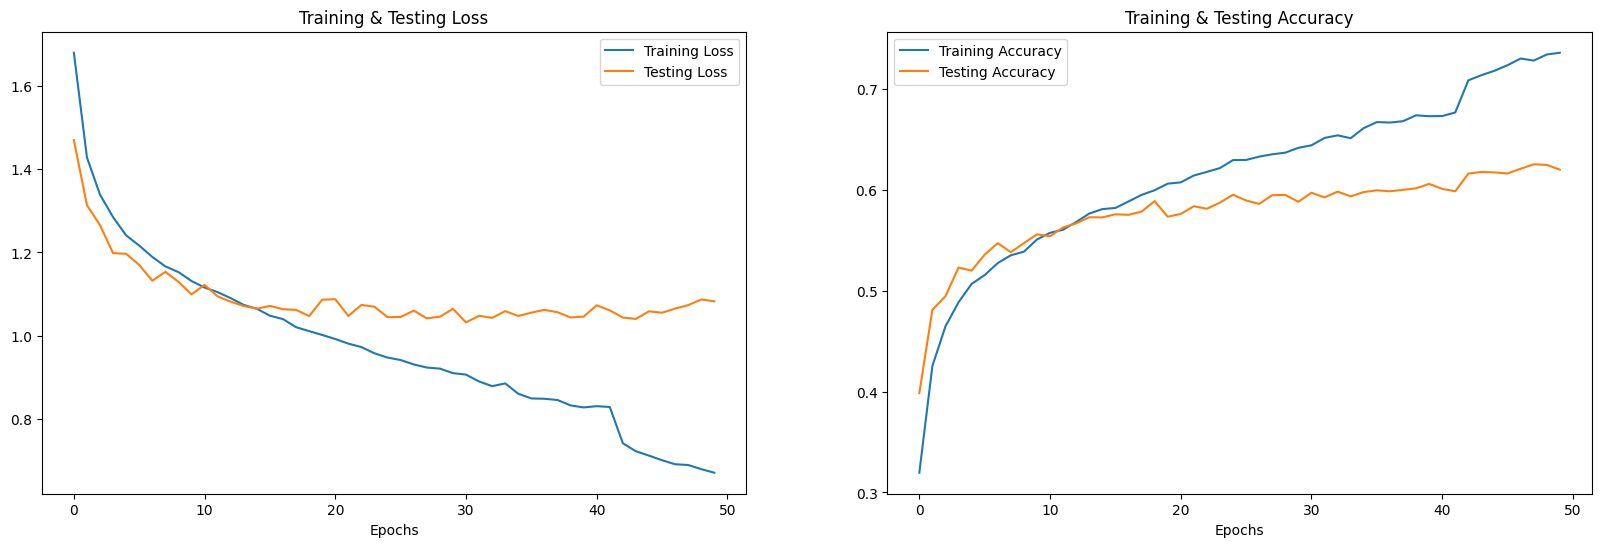

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

286/286 [==============================] - 15s 52ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          neutral          fear
1          disgust       disgust
2             fear          fear
3            happy          fear
4            happy         happy
5            angry       disgust
6             fear           sad
7         surprise      surprise
8            happy         angry
9          neutral       neutral

## Result and Analysis

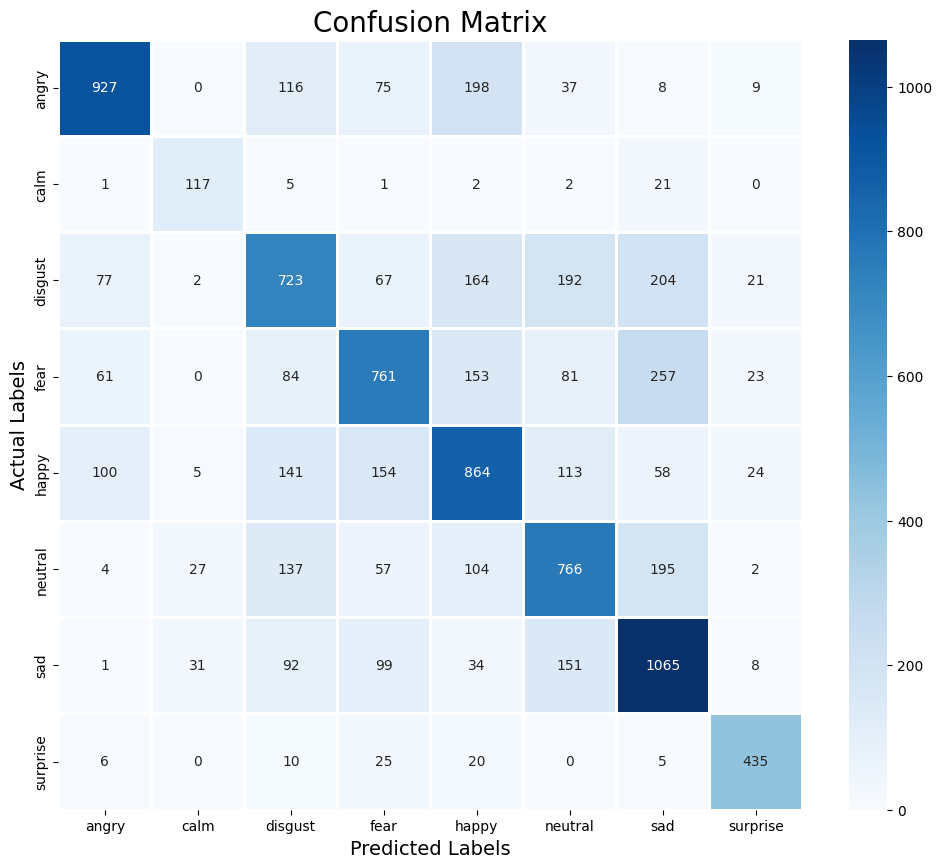

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.79      0.68      0.73      1370
        calm       0.64      0.79      0.71       149
     disgust       0.55      0.50      0.52      1450
        fear       0.61      0.54      0.57      1420
       happy       0.56      0.59      0.58      1459
     neutral       0.57      0.59      0.58      1292
         sad       0.59      0.72      0.65      1481
    surprise       0.83      0.87      0.85       501

    accuracy                           0.62      9122
   macro avg       0.64      0.66      0.65      9122
weighted avg       0.62      0.62      0.62      9122

